In [ ]:
# imports & load
import os, sys, json, textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# load the file path from the environment variable
PARQUET_PATH = [
    "ForParticipants/csv_data_extracted/harmonized_trade_data.parquet",
]

assert PARQUET_PATH is not None, f"Could not find parquet in: {PARQUET_PATH}. Please set PARQUET_PATH."

df = pd.read_parquet(PARQUET_PATH)

# expected columns:
# origin, destination, hs6, hs4, trade_flow, month, value
expected_cols = {"origin","destination","hs6","hs4","trade_flow","month","value"}
missing_cols = expected_cols - set(df.columns)
assert not missing_cols, f"Missing expected columns: {missing_cols}"

# standardize types
df["hs6"] = df["hs6"].astype(str).str.zfill(6)
df["hs4"] = df["hs4"].astype(str).str.zfill(4)
df["trade_flow"] = df["trade_flow"].astype(str)  # "Export"/"Import"
df["month"] = pd.to_datetime(df["month"])        # YYYY-MM-01 expected
df["value"] = pd.to_numeric(df["value"], errors="coerce").fillna(0.0)

# convenience subsets
USA = df.query("origin == 'USA' or destination == 'USA'").copy()
CHN = df.query("origin == 'CHN' or destination == 'CHN'").copy()

USA.shape, CHN.shape, df.shape


((19126204, 7), (11791991, 7), (29982706, 7))

In [3]:
# basic structure & missing/negative/duplicates

def structural_checks(data, label="DATA"):
    print(f"\n=== {label}: HEAD ===")
    display(data.head(3))

    print(f"\n=== {label}: NULL COUNTS ===")
    display(data[["origin","destination","hs6","hs4","trade_flow","month","value"]].isna().sum())

    print(f"\n=== {label}: NEGATIVE VALUES ===")
    neg = (data["value"] < 0).sum()
    print(f"negative rows: {neg}")

    print(f"\n=== {label}: ZERO VALUES (share) ===")
    zero_share = (data["value"] == 0).mean()
    print(f"{zero_share:.2%} of rows have value == 0")

    print(f"\n=== {label}: DUPLICATES ON KEY ===")
    key = ["month","origin","destination","hs6","trade_flow"]
    dups = data.duplicated(key).sum()
    print(f"duplicates on {key}: {dups}")

    if dups:
        dup_df = data[data.duplicated(key, keep=False)].sort_values(key)
        print("sample duplicates:")
        display(dup_df.head(10))

    print(f"\n=== {label}: HS4 vs HS6 consistency ===")
    mismatch = (data["hs4"] != data["hs6"].str[:4]).sum()
    print(f"rows where hs4 != hs6[:4]: {mismatch}")

structural_checks(USA, "USA")
structural_checks(CHN, "CHN")



=== USA: HEAD ===


,origin,destination,hs6,hs4,trade_flow,month,value
148162,CHN,USA,010619,0106,Exports,2023-01-01,483231
148163,CHN,USA,010619,0106,Imports,2023-01-01,202264
148164,CHN,USA,010649,0106,Imports,2023-01-01,1318



=== USA: NULL COUNTS ===


origin         0
destination    0
hs6            0
hs4            0
trade_flow     0
month          0
value          0
dtype: int64


=== USA: NEGATIVE VALUES ===
negative rows: 0

=== USA: ZERO VALUES (share) ===
46.56% of rows have value == 0

=== USA: DUPLICATES ON KEY ===
duplicates on ['month', 'origin', 'destination', 'hs6', 'trade_flow']: 10547613
sample duplicates:


,origin,destination,hs6,hs4,trade_flow,month,value
148162,CHN,USA,010619,0106,Exports,2023-01-01,483231
293834,CHN,USA,010619,0106,Exports,2023-01-01,11500
148163,CHN,USA,010619,0106,Imports,2023-01-01,202264
293835,CHN,USA,010619,0106,Imports,2023-01-01,3501
148164,CHN,USA,010649,0106,Imports,2023-01-01,1318
293837,CHN,USA,010649,0106,Imports,2023-01-01,181
148166,CHN,USA,020120,0201,Imports,2023-01-01,299005
293838,CHN,USA,020120,0201,Imports,2023-01-01,67852
148167,CHN,USA,020130,0201,Imports,2023-01-01,1721874
293839,CHN,USA,020130,0201,Imports,2023-01-01,18428065



=== USA: HS4 vs HS6 consistency ===
rows where hs4 != hs6[:4]: 0

=== CHN: HEAD ===


,origin,destination,hs6,hs4,trade_flow,month,value
0,CHN,\N,030359,0303,Exports,2023-01-01,45000
1,CHN,\N,070310,0703,Exports,2023-01-01,2200
2,CHN,\N,070320,0703,Exports,2023-01-01,600



=== CHN: NULL COUNTS ===


origin         0
destination    0
hs6            0
hs4            0
trade_flow     0
month          0
value          0
dtype: int64


=== CHN: NEGATIVE VALUES ===
negative rows: 0

=== CHN: ZERO VALUES (share) ===
1.50% of rows have value == 0

=== CHN: DUPLICATES ON KEY ===
duplicates on ['month', 'origin', 'destination', 'hs6', 'trade_flow']: 2751178
sample duplicates:


,origin,destination,hs6,hs4,trade_flow,month,value
302166,CHN,ALB,520821,5208,Exports,2023-01-01,22969
437647,CHN,ALB,520821,5208,Exports,2023-01-01,27510
302185,CHN,ALB,540761,5407,Exports,2023-01-01,91903
437650,CHN,ALB,540761,5407,Exports,2023-01-01,16593
302213,CHN,ALB,580133,5801,Exports,2023-01-01,8752
437652,CHN,ALB,580133,5801,Exports,2023-01-01,8
302235,CHN,ALB,600192,6001,Exports,2023-01-01,872793
437653,CHN,ALB,600192,6001,Exports,2023-01-01,4
302240,CHN,ALB,600632,6006,Exports,2023-01-01,60990
437656,CHN,ALB,600632,6006,Exports,2023-01-01,2



=== CHN: HS4 vs HS6 consistency ===
rows where hs4 != hs6[:4]: 0



=== USA: Months present (2023-01-01 → 2024-12-01) ===


,month,value
0,2023-01-01,479171754818
1,2023-02-01,432243858464
2,2023-03-01,507041258772
3,2023-04-01,469421598476
4,2023-05-01,487617897889


trade_flow,Exports,Imports
month,,
2023-01-01,209896828678,269274926140
2023-02-01,186100913015,246142945449
2023-03-01,228136580122,278904678650
2023-04-01,205410205238,264011393238
2023-05-01,209155446784,278462451105


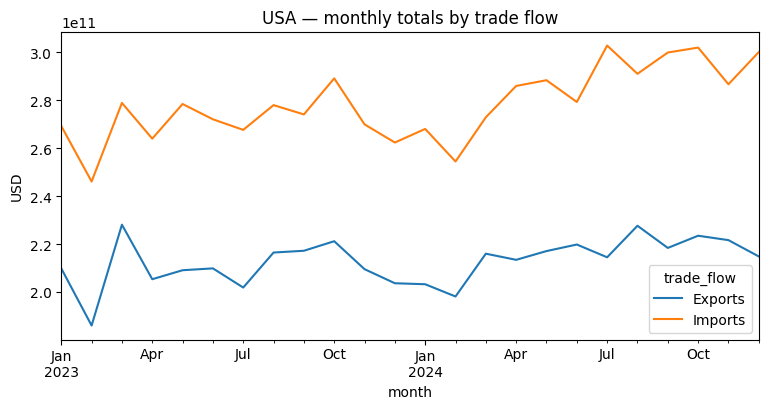


USA: number of rows per month (rough density check)


,rows
month,
2023-01,302649
2023-02,434296
2023-03,550568
2023-04,663035
2023-05,717737
2023-06,829054
2023-07,901361
2023-08,948270
2023-09,1003361



=== CHN: Months present (2023-01-01 → 2024-12-01) ===


,month,value
0,2023-01-01,535832246454
1,2023-02-01,453469892734
2,2023-03-01,587958742647
3,2023-04-01,546499456709
4,2023-05-01,547745824672


trade_flow,Exports,Imports
month,,
2023-01-01,305368107304,230464139150
2023-02-01,225644458350,227825434384
2023-03-01,329770419731,258188322916
2023-04-01,308212335210,238287121499
2023-05-01,294163174581,253582650091


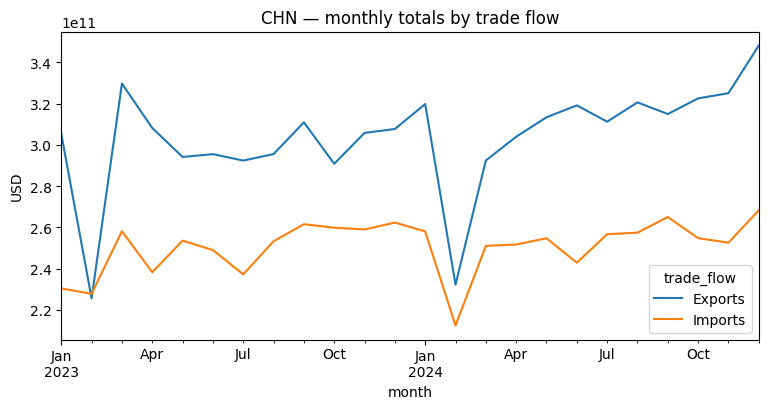


CHN: number of rows per month (rough density check)


,rows
month,
2023-01,450916
2023-02,419533
2023-03,484532
2023-04,483590
2023-05,482549
2023-06,481227
2023-07,493110
2023-08,501935
2023-09,507815


In [4]:
# monthly completeness & coverage

def monthly_coverage(data, label="DATA"):
    by_month = data.groupby("month", as_index=False)["value"].sum()
    print(f"\n=== {label}: Months present ({by_month['month'].min().date()} → {by_month['month'].max().date()}) ===")
    display(by_month.head())

    # plot totals (exports vs imports separately)
    piv = data.pivot_table(index="month", columns="trade_flow", values="value", aggfunc="sum").fillna(0)
    display(piv.head())

    ax = piv.plot(figsize=(9,4), title=f"{label} — monthly totals by trade flow")
    ax.set_xlabel("month")
    ax.set_ylabel("USD")
    plt.show()

    # simple gap check per year-month
    counts = data.groupby([data["month"].dt.to_period("M")]).size()
    print(f"\n{label}: number of rows per month (rough density check)")
    display(counts.sort_index().to_frame("rows"))

monthly_coverage(USA, "USA")
monthly_coverage(CHN, "CHN")


In [5]:
# CELL 3 — top partners per month

def top_partners_per_month(data, home_iso, flow="Export", topn=3, month_limit=6):
    # if flow is Export: origin == home_iso, group by destination
    # if flow is Import: destination == home_iso, group by origin
    if flow == "Export":
        d = data.query("origin == @home_iso and trade_flow == 'Export'")
        grp_cols = ["month","destination"]
    else:
        d = data.query("destination == @home_iso and trade_flow == 'Import'")
        grp_cols = ["month","origin"]

    agg = d.groupby(grp_cols, as_index=False)["value"].sum()
    agg["rank"] = agg.groupby("month")["value"].rank(method="first", ascending=False)
    top = agg.query("rank <= @topn").sort_values(["month","rank"])

    # show recent few months
    recent_months = sorted(top["month"].unique())[-month_limit:]
    out = top[top["month"].isin(recent_months)]
    return out

usa_top_exp = top_partners_per_month(USA, "USA", "Export")
usa_top_imp = top_partners_per_month(USA, "USA", "Import")
chn_top_exp = top_partners_per_month(CHN, "CHN", "Export")
chn_top_imp = top_partners_per_month(CHN, "CHN", "Import")

print("USA — top export destinations (recent months)")
display(usa_top_exp)

print("USA — top import origins (recent months)")
display(usa_top_imp)

print("CHN — top export destinations (recent months)")
display(chn_top_exp)

print("CHN — top import origins (recent months)")
display(chn_top_imp)


USA — top export destinations (recent months)


,month,destination,value,rank


USA — top import origins (recent months)


,month,origin,value,rank


CHN — top export destinations (recent months)


,month,destination,value,rank


CHN — top import origins (recent months)


,month,origin,value,rank


In [6]:
# CELL 4 — hs6 sums must equal hs4 sums when grouped

def hs_aggregation_check(data, label="DATA"):
    # recompute hs4 from hs6 and compare grouped sums at (month, origin, destination, hs4, trade_flow)
    g6 = data.groupby(["month","origin","destination","hs6","trade_flow"], as_index=False)["value"].sum()
    # aggregate to hs4
    g6["hs4_from_hs6"] = g6["hs6"].str[:4]
    g4_from6 = g6.groupby(["month","origin","destination","hs4_from_hs6","trade_flow"], as_index=False)["value"].sum()
    g4_from6 = g4_from6.rename(columns={"hs4_from_hs6":"hs4"})

    # aggregate original to hs4 directly
    g4_direct = data.groupby(["month","origin","destination","hs4","trade_flow"], as_index=False)["value"].sum()

    # join & diff
    merged = g4_direct.merge(g4_from6, on=["month","origin","destination","hs4","trade_flow"], how="outer", suffixes=("_direct","_from6")).fillna(0)
    merged["abs_diff"] = (merged["value_direct"] - merged["value_from6"]).abs()
    total_diff = merged["abs_diff"].sum()
    max_diff = merged["abs_diff"].max()

    print(f"{label}: total absolute diff = {total_diff:,.2f}, max row diff = {max_diff:,.2f}")
    display(merged.sort_values("abs_diff", ascending=False).head(5))

hs_aggregation_check(USA, "USA")
hs_aggregation_check(CHN, "CHN")


USA: total absolute diff = 0.00, max row diff = 0.00


,month,origin,destination,hs4,trade_flow,value_direct,value_from6,abs_diff
0,2023-01-01,CHN,USA,0106,Exports,494903,494903,0
2240509,2024-05-01,USA,OMN,9021,Exports,215208,215208,0
2240499,2024-05-01,USA,OMN,9014,Exports,25496,25496,0
2240500,2024-05-01,USA,OMN,9015,Exports,158115,158115,0
2240501,2024-05-01,USA,OMN,9015,Imports,0,0,0


CHN: total absolute diff = 0.00, max row diff = 0.00


,month,origin,destination,hs4,trade_flow,value_direct,value_from6,abs_diff
0,2023-01-01,CHN,ABW,2402,Exports,638715,638715,0
2208154,2024-05-01,CHN,CHE,3903,Imports,6760,6760,0
2208144,2024-05-01,CHN,CHE,3822,Exports,991966,991966,0
2208145,2024-05-01,CHN,CHE,3822,Imports,2623386,2623386,0
2208146,2024-05-01,CHN,CHE,3823,Exports,1330,1330,0


In [7]:
# CELL 5 — spike flags using pct_change

def spike_flags(data, label="DATA", threshold=5.0, min_value=1_000):
    # series definition: (origin, destination, hs6, trade_flow)
    g = (data
         .sort_values(["origin","destination","hs6","trade_flow","month"])
         .groupby(["origin","destination","hs6","trade_flow"]))

    d = data.copy()
    d["pct_chg"] = g["value"].pct_change()
    d["flag_spike"] = (d["pct_chg"].abs() >= threshold) & (d["value"].abs() >= min_value)

    print(f"{label}: spike rows (|pct_change| >= {threshold} and value >= {min_value})")
    out = d.loc[d["flag_spike"], ["month","origin","destination","hs6","hs4","trade_flow","value","pct_chg"]]
    display(out.sort_values(["month","origin","destination"]).head(20))
    print(f"total spikes flagged: {out.shape[0]}")
    return out

usa_spikes = spike_flags(USA, "USA")
chn_spikes = spike_flags(CHN, "CHN")


USA: spike rows (|pct_change| >= 5.0 and value >= 1000)


,month,origin,destination,hs6,hs4,trade_flow,value,pct_chg
293839,2023-01-01,CHN,USA,020130,0201,Imports,18428065,9.702331
293854,2023-01-01,CHN,USA,030389,0303,Exports,6849919,44.286924
293867,2023-01-01,CHN,USA,030499,0304,Exports,242305,95.922000
293902,2023-01-01,CHN,USA,051199,0511,Exports,4752663,13.370351
293905,2023-01-01,CHN,USA,060290,0602,Exports,3177358,5.354284
293924,2023-01-01,CHN,USA,071190,0711,Exports,296445,57.970559
293925,2023-01-01,CHN,USA,071220,0712,Exports,1050808,55.659549
293927,2023-01-01,CHN,USA,071232,0712,Exports,787473,12.196913
293929,2023-01-01,CHN,USA,071234,0712,Exports,1166739,5.819884
293930,2023-01-01,CHN,USA,071239,0712,Exports,295017,5.634366


total spikes flagged: 4080073
CHN: spike rows (|pct_change| >= 5.0 and value >= 1000)


,month,origin,destination,hs6,hs4,trade_flow,value,pct_chg
437706,2023-01-01,CHN,ALB,620433,6204,Imports,4051,11.464615
437715,2023-01-01,CHN,ALB,620452,6204,Imports,68709,12.430219
437717,2023-01-01,CHN,ALB,620461,6204,Imports,76197,8.728933
437718,2023-01-01,CHN,ALB,620462,6204,Imports,198455,19.153854
437720,2023-01-01,CHN,ALB,620463,6204,Imports,23005,74.426230
437727,2023-01-01,CHN,ALB,620630,6206,Imports,38202,443.209302
437733,2023-01-01,CHN,ALB,621132,6211,Imports,18795,217.546512
437736,2023-01-01,CHN,ALB,621142,6211,Imports,33751,295.061404
438117,2023-01-01,CHN,ALB,950300,9503,Exports,2074526,19.687954
302777,2023-01-01,CHN,ARE,071234,0712,Exports,31400,5.388606


total spikes flagged: 1982754


In [8]:
# CELL 6 — length and sparsity

def series_depth_stats(data, label="DATA"):
    key = ["origin","destination","hs6","trade_flow"]
    stats = (data.groupby(key)
                  .agg(n_months=("month", lambda s: s.dt.to_period("M").nunique()),
                       total_value=("value","sum"),
                       last_month=("month","max"))
                  .reset_index())
    print(f"{label}: distribution of n_months per series")
    display(stats["n_months"].describe())
    # long tail view
    tail = stats.sort_values("total_value").head(10)
    print(f"{label}: 10 smallest series by total_value")
    display(tail)
    return stats

usa_stats = series_depth_stats(USA, "USA")
chn_stats = series_depth_stats(CHN, "CHN")


USA: distribution of n_months per series


count    524594.00000
mean         16.35282
std           7.58124
min           1.00000
25%          10.00000
50%          19.00000
75%          24.00000
max          24.00000
Name: n_months, dtype: float64

USA: 10 smallest series by total_value


,origin,destination,hs6,trade_flow,n_months,total_value,last_month
303400,USA,KOR,382569,Imports,12,0,2023-12-01
221117,USA,GUY,271311,Imports,21,0,2024-12-01
221113,USA,GUY,271121,Imports,10,0,2024-12-01
221111,USA,GUY,271114,Imports,13,0,2024-12-01
221109,USA,GUY,271112,Imports,21,0,2024-12-01
221106,USA,GUY,271019,Imports,21,0,2024-12-01
221101,USA,GUY,270799,Imports,10,0,2023-12-01
221098,USA,GUY,270730,Imports,8,0,2024-12-01
221056,USA,GUY,250300,Imports,18,0,2024-12-01
221119,USA,GUY,271320,Imports,10,0,2023-12-01


CHN: distribution of n_months per series


count    723571.000000
mean         12.494714
std           9.282711
min           1.000000
25%           3.000000
50%          11.000000
75%          23.000000
max          24.000000
Name: n_months, dtype: float64

CHN: 10 smallest series by total_value


,origin,destination,hs6,trade_flow,n_months,total_value,last_month
394913,CHN,LVA,821290,Exports,1,0,2024-04-01
381093,CHN,LIE,961610,Exports,1,0,2024-12-01
167108,CHN,DNK,291819,Imports,1,0,2024-03-01
34736,CHN,AUT,410791,Exports,1,0,2023-04-01
435652,CHN,MNG,540751,Exports,1,0,2023-07-01
66337,CHN,BHS,251512,Exports,1,0,2023-12-01
141804,CHN,CUB,520952,Exports,1,0,2023-11-01
538703,CHN,PYF,611790,Exports,1,0,2023-01-01
141803,CHN,CUB,520951,Exports,1,0,2023-11-01
396925,CHN,MAC,340250,Imports,1,0,2024-11-01


In [17]:
# CELL 7 — top products

def top_products_by_year(data, label="DATA", level="hs6", flow="Export", year=2024, topn=20):
    d = data.copy()
    d = d[d["trade_flow"] == flow]
    d = d[d["month"].dt.year == year]
    grp = d.groupby(level, as_index=False)["value"].sum().sort_values("value", ascending=False).head(topn)
    print(f"{label}: Top {topn} {level.upper()} for {flow} in {year}")
    display(grp)

for lvl in ["hs6","hs4"]:
    top_products_by_year(USA, "USA", level=lvl, flow="Export", year=2024)
    top_products_by_year(USA, "USA", level=lvl, flow="Import", year=2024)
    top_products_by_year(CHN, "CHN", level=lvl, flow="Export", year=2024)
    top_products_by_year(CHN, "CHN", level=lvl, flow="Import", year=2024)


USA: Top 20 HS6 for Export in 2024


,hs6,value


USA: Top 20 HS6 for Import in 2024


,hs6,value


CHN: Top 20 HS6 for Export in 2024


,hs6,value


CHN: Top 20 HS6 for Import in 2024


,hs6,value


USA: Top 20 HS4 for Export in 2024


,hs4,value


USA: Top 20 HS4 for Import in 2024


,hs4,value


CHN: Top 20 HS4 for Export in 2024


,hs4,value


CHN: Top 20 HS4 for Import in 2024


,hs4,value
